### **Notebook 3 - Pre-processing and modeling: ARMA models** 

### Introduction

In this section, I'll explore different autoregressive moving-average models (AR MA) to generate predictions of the AQI. For that, I'll pre-process the data and plot the autocorrelation and partial autocorrelation that helps to inform the model building process. The models will be assessed and compared to find the best performing one. A short summary is provided at the end of the notebook.

**Table of content:**

Data preprocessing:

- Stationarity
- Differencing
- Train-test split

Modeling:

- Baseline model
- Autocorrelation and partial autocorrelation
- ARIMA model
- SARIMA(X) model

Summary

***

### Loading data and importing libraries

In [2]:
# Importing libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.api import tsa
import statsmodels.api as sm

In [3]:
# Loading dataset

aqi_df = pd.read_csv('data/cleaned_aqi.csv', parse_dates=['Date'], index_col='Date')
aqi_df.sample(5)

,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_name,lat,lng,population,density,timezone,Year,Month,Day
Date,,,,,,,,,,,,,,
2007-07-10,50,Good,PM2.5,19,Los Angeles,California,34.1141,-118.4068,12531334.0,3267.0,America/Los_Angeles,2007,7,10
1999-04-21,73,Moderate,PM2.5,18,Los Angeles,California,34.1141,-118.4068,12531334.0,3267.0,America/Los_Angeles,1999,4,21
1998-03-25,60,Moderate,NO2,18,Los Angeles,California,34.1141,-118.4068,12531334.0,3267.0,America/Los_Angeles,1998,3,25
2020-11-10,58,Moderate,PM2.5,20,Los Angeles,California,34.1141,-118.4068,12531334.0,3267.0,America/Los_Angeles,2020,11,10
2017-01-11,53,Moderate,PM2.5,21,Los Angeles,California,34.1141,-118.4068,12531334.0,3267.0,America/Los_Angeles,2017,1,11


In [4]:
# Creating a new dataframe with target variable only and resampling to monthly averages  

dates_aqi_df = aqi_df['AQI']
dates_aqi_df = pd.DataFrame(dates_aqi_df)

air_quality_monthly = dates_aqi_df.resample('M').mean()

In [5]:
# Checking the shape of the dataframe we use for modeling

air_quality_monthly.shape

(504, 1)

***

### **Data pre-processing**

### Stationarity

 

We can test whether our time-series is stationary or not by using a statistical test called ADF.

An ADF test helps in understanding if the series is stationary or not by testing the presence of a unit root in the series. The null and alternate hypothesis of the test are:

H0: The series has a unit root and is assumed to be stationary.

H1: The series has no unit root.

Source and further reading on ADF <a href="https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html" target="_blank">**here**</a>.

In [6]:
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(air_quality_monthly['AQI'])
print('ADF Statistic:', test_result[0])
print('p-value:', test_result[1])
print('Critical Values:', test_result[4])

ADF Statistic: -1.80717480068726
p-value: 0.3769054673237746
Critical Values: {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}


The p-value of the ADF test is ~0.38, that is bigger than our threshold of 0.05. This means that we failed to reject H0 and there's evidence that our series might be non-stationary. Next we'll use differencing and log transformation to transform our data into a stationary series.

### Differencing

Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. Transformations such as logarithms can also help to stabilise the variance of a time series. 

We'll use a month-on-month difference and see how our new differenced data compares to the original series.

In [7]:
# Monthly difference

air_quality_monthly['AQI_monthly_diff'] = np.log(air_quality_monthly['AQI']).diff()

# Dropping the empty values (the first value is always empty as there's no month prior to substract it from)

air_quality_monthly.dropna(inplace=True)
air_quality_monthly.head(5)

,AQI,AQI_monthly_diff
Date,,
1980-02-29,105.827586,0.020838
1980-03-31,111.387097,0.051200
1980-04-30,149.100000,0.291606
1980-05-31,130.451613,-0.133615
1980-06-30,219.766667,0.521564


In [8]:
# Plotting original and differenced datasets

titles = 'Original time series', 'Differenced time series'

fig = make_subplots(rows=2, cols=1, subplot_titles=titles)

fig.add_trace(
        go.Scatter(x=air_quality_monthly.index, y=air_quality_monthly['AQI']),
        row=1,
        col=1)

fig.add_trace(
        go.Scatter(x=air_quality_monthly.index, y=air_quality_monthly['AQI_monthly_diff']),
        row=2,
        col=1)

fig.update_layout(height=600, width=1200, showlegend=False)
fig.show()

We can see that the series now doesn't have clear trends, it still shows some seasonality and has a relatively stable variance. 
I will test again if our differenced series is stationary.

In [9]:
# Testing stationarity on the differenced series

result = adfuller(air_quality_monthly['AQI_monthly_diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

ADF Statistic: -17.82861480274919
p-value: 3.1399263935834376e-30
Critical Values: {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}


The p-value of the ADF test is now tiny, and is smaller than the 0.05 threshold. This means that we can reject the H0 and assume that our series is stationary, i.e. differencing the series definitely did help in making it stationary.

Since the model(s) I'll use in this secton have built-in differencing, I'll keep using the original series, and use the built-in parameter of the model. This way the results don't need to be transformed back to their original form and can be interpreted readily. However, for the baseline model I need stationary data, so I'll create a train-test split to be able to get the baseline model performance.

### Test-train split

Before building the model, I set aside the test set so the accuracy of the model(s) can be measured. There are 503 months in the series, so I'll set aside ~20% of them for testing, i.e. approximately the last 8 years of the time-series.

I'll name the train set `remainder` for now, as I might need to further split it into train and validation subsets. 

Since the baseline model (predicting the mean over the training set) needs stationary data, I'll split the differenced series into train and test sets as well. These will be named train and test as no hyperparameter tuning will be performed.

In [165]:
# Creating the train and test sets

remainder = pd.DataFrame(air_quality_monthly.loc[air_quality_monthly.index <= '2013-01-01', 'AQI'])
test = pd.DataFrame(air_quality_monthly.loc[air_quality_monthly.index > '2013-01-01', 'AQI'])

# Creating the train and test sets using the differenced data

train_baseline = pd.DataFrame(air_quality_monthly.loc[air_quality_monthly.index <= '2013-01-01', 'AQI_monthly_diff'])
test_baseline = pd.DataFrame(air_quality_monthly.loc[air_quality_monthly.index > '2013-01-01', 'AQI_monthly_diff'])


In [11]:
# Visualizing the train-test split

import plotly.graph_objects as go


fig = go.Figure()
fig.add_trace(go.Scatter(x=remainder.index, y=remainder['AQI'], mode='lines', name='Train', line=dict(color='blue')))


fig.add_trace(go.Scatter(x=test.index, y=test['AQI'], mode='lines', name='Test', line=dict(color='green')))

fig.add_shape(
    type='line',
    x0=test.index[0],
    x1=test.index[0],
    y0=min(min(remainder['AQI']), min(test['AQI'])),
    y1=max(max(remainder['AQI']), max(test['AQI'])),
    line=dict(color='red', width=2, dash='dash')
)

fig.update_layout(
    yaxis_title='AQI_monthly_diff',
    xaxis_title='Date',
    title='Train (remainder) and test sets with train-test split highlighted')

fig.show()

***
### **Modeling**

### Baseline model

First I'll build a baseline model that makes simple forecasts, so that we have something to compare to the performance of the more robust models. The simplest method to use with stationary series is to predict the mean over the training set.

In [194]:
full_index = pd.concat([train_baseline, test_baseline]).index
base_line = np.full(full_index.shape, np.mean(train_baseline))

predictions = pd.Series(data=base_line, index=full_index)

In [195]:
# Plotting the mean over the training and test set

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_baseline.index, y=train_baseline['AQI_monthly_diff'], name='Train'))
fig.add_trace(go.Scatter(x=test_baseline.index, y=test_baseline['AQI_monthly_diff'], name='Test'))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, name='Mean Prediction'))

fig.update_layout(
    yaxis_title='AQI values', 
    xaxis_title='Date',
    title='Change in AQI values over prior month and mean prediction'
)
fig.show()

This is a very simple model with a heavy over- and underestimations both on the training and test. We can quantify the performance by using the mean absolute percentage error.

Absolute mean percentage error tells us the how off the predictions are from the actual numbers on average. Since it can only take values between 0-100%, it's not sensitive to the scales of the predictions and therefore allows meaningful comparison across the models.

In [196]:
# Calculating the MAPE score for the baseline model

mape_train = round(np.mean(abs(train_baseline['AQI_monthly_diff'] - predictions[train_baseline.index] / train_baseline['AQI_monthly_diff'])) * 100, 2)
mape_test = round(np.mean(abs(test_baseline['AQI_monthly_diff'] - predictions[test_baseline.index] / test_baseline['AQI_monthly_diff'])) * 100, 2)

print(f'The MAPE for the train set is {mape_train}%.')
print(f'The MAPE for the test set is {mape_test}%.')

The MAPE for the train set is 20.59%.
The MAPE for the test set is 18.96%.


Let's save these baseline results.

| Model  |  Train results |  Test results |
|---|---|---|
|  Baseline (mean prediction) | 20.59%  | 18.96%  |

### Autocorrelation and partial autocorrelation

To build more complex autoregressive models, I'll need to first plot the autocorrelation (ACF) and partial autocorrelations (PACF), so it can inform about the right parameters for the model.

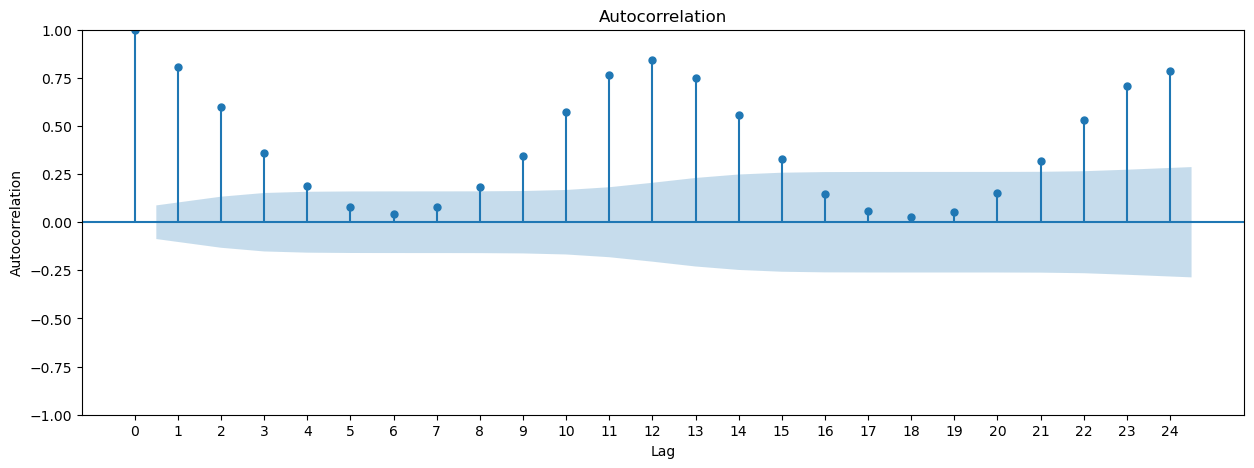

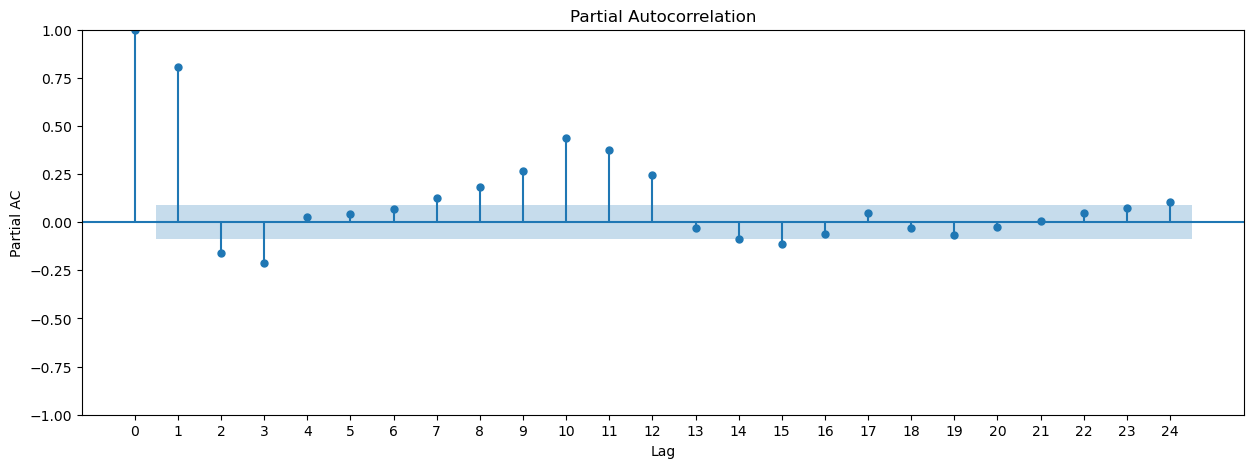

In [15]:
# Plotting ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(air_quality_monthly['AQI'], lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xticks(range(0,25))
plt.show()

plt.figure(figsize=(15, 5))
plot_pacf(air_quality_monthly['AQI'], lags=24, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.xticks(range(0,25))
plt.ylabel('Partial AC')
plt.show()

We can see that the series have strong yearly seasonality (as seen during EDA as well) and this isn't helpful in determining the right parameters for the ARIMA model. So I'll plot the yearly differenced values, which should completely remove the seasonality and inform about the parameters for the model.

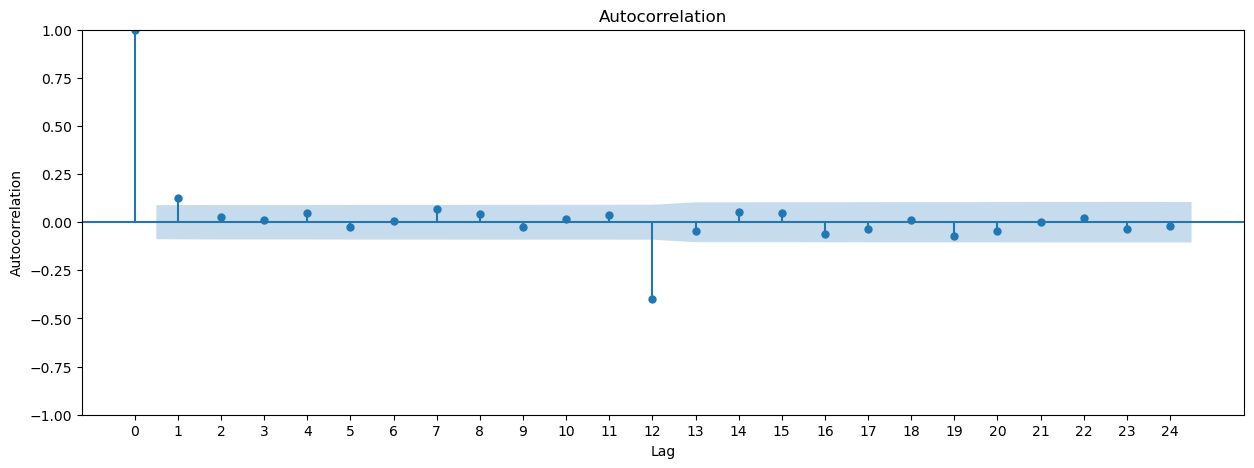

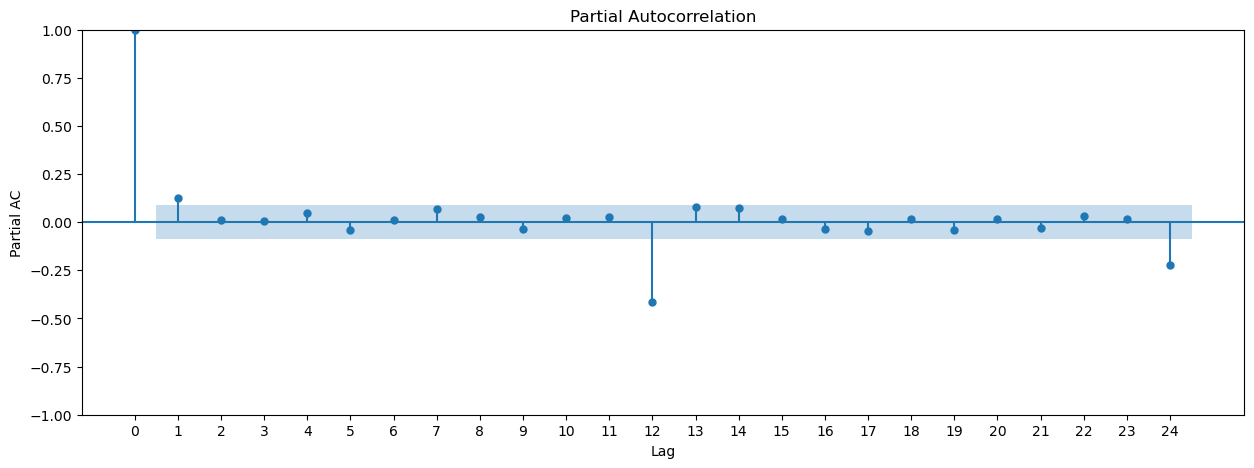

In [16]:
# Plotting ACF and PACF using yearly differenced values

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(air_quality_monthly['AQI'].diff(12).dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.xticks(range(0,25))
plt.show()

plt.figure(figsize=(15, 5))
plot_pacf(air_quality_monthly['AQI'].diff(12).dropna(), lags=24, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.xticks(range(0,25))
plt.ylabel('Partial AC')
plt.show()

We removed the seasonality and can see that both for p and q the best parameters seem to be 1. We can build the ARIMA model and tune it along these parameters to find the best performing model.

### ARIMA model

Before starting to build the model and optimize the hyperparameters, I'll split the remainder set into train and validation sets, so I can see how the model does using different parameters without having to toich the test set. I'll use ~20% of the dataframe for validation.

In [128]:
# Train and validation split

train = pd.DataFrame(remainder.loc[remainder.index <= '2005-01-01', 'AQI'])
validation = pd.DataFrame(remainder.loc[remainder.index > '2005-01-01', 'AQI'])

As we can could see in the ACF and PACF plots, the best p and q values seem to be around 1, so I'll test a range between 0-1 for `p` and 0-2 for `q`. The data is not differenced, so `d` must be at least 1. I'll test 1 and 2 for `d`.

To find the best model, I'll look at the mean squared error score for the both the training and validations sets. The model with the lowest MSE will be picked to build the final ARIMA model.

In [198]:
# Looping through different p, d, q parameters

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

p_values = range(0, 2)
d_values = range(1, 3)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            predictions = model_fit.predict(start=0, end=len(train) + len(validation)-1)
            mse_train = round(mean_squared_error(train['AQI'], predictions[train.index]), 2)
            mse_val = round(mean_squared_error(validation['AQI'], predictions[validation.index]), 2)
            print(f'ARIMA model{order}, MSE train score: {mse_train}, MSE validation score: {mse_val}')

ARIMA model(0, 1, 0), MSE train score: 1118.02, MSE validation score: 888.67
ARIMA model(0, 1, 1), MSE train score: 1116.7, MSE validation score: 883.85
ARIMA model(0, 1, 2), MSE train score: 1099.66, MSE validation score: 857.8
ARIMA model(0, 2, 0), MSE train score: 2123.51, MSE validation score: 92703.6
ARIMA model(0, 2, 1), MSE train score: 1154.51, MSE validation score: 1025.06
ARIMA model(0, 2, 2), MSE train score: 1152.95, MSE validation score: 1001.99
ARIMA model(1, 1, 0), MSE train score: 1116.45, MSE validation score: 883.06
ARIMA model(1, 1, 1), MSE train score: 1115.61, MSE validation score: 886.12
ARIMA model(1, 1, 2), MSE train score: 962.72, MSE validation score: 866.03
ARIMA model(1, 2, 0), MSE train score: 1541.94, MSE validation score: 5716.39
ARIMA model(1, 2, 1), MSE train score: 1152.63, MSE validation score: 1000.05
ARIMA model(1, 2, 2), MSE train score: 1148.04, MSE validation score: 993.52


/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



The lowest MSE train and validation score are performed by the ARIMA model (1, 1, 2), so I'll use these parameters to fit the model on the whole training set. Using this model, I'll plot the predictions and check the absolute mean percentage error score to evaluate and compare the model.

In [199]:
# Building the model with the best hyperparameters 

p = 1
d = 1
q = 2

arima_model = ARIMA(remainder, order=(p, d, q))
arima_model_fit = arima_model.fit()

arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                  395
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1873.981
Date:                Wed, 27 Mar 2024   AIC                           3755.961
Time:                        20:20:05   BIC                           3771.867
Sample:                    02-29-1980   HQIC                          3762.264
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6156      0.058     10.650      0.000       0.502       0.729
ma.L1         -0.7979      0.079    -10.110      0.000      -0.953      -0.643
ma.L2         -0.1722      0.073     -2.362      0.018      -0.315      -0.029
sigma2       788.9865     53.661     14.703      0.000     683.812     894.161
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                27.71
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [200]:
# Predictions using the model 

arima_predictions = arima_model_fit.predict(start=0, end=len(remainder)+len(test)-1)

In [201]:
# Plotting the predictions over the whole training and test sets

fig = go.Figure()
fig.add_trace(go.Scatter(x=remainder.index, y=remainder['AQI'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test['AQI'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=arima_predictions.index, y=arima_predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='AQI values', 
    xaxis_title='Date',
    title='AQI predictions over train and test sets'
)
fig.show()

We can see that the model nicely captures the trends and the seasonality in the training set, but it doesn't do well on the test set and the predictions flatten out towards the end of the time-series. We can quantify how well the model does by calculating the MAPE.

In [187]:
mape_train = np.mean(abs(remainder['AQI'] - arima_predictions[remainder.index]) / remainder['AQI']) *100
mape_test = np.mean(abs(test['AQI'] - arima_predictions[test.index]) / test['AQI']) *100

print(f'The MAPE for the train set is {round(mape_train, 2)}%.')
print(f'The MAPE for the test set is {round(mape_test, 2)}%.')

The MAPE for the train set is 18.46%.
The MAPE for the test set is 25.53%.


We can see an improvement in the MAPE score for the train set, however, the results didn't improve on the test set. Let's save these results and move on to the next model.

| Model  |  Train results |  Test results |
|---|---|---|
|  Baseline (mean prediction) | 20.59%  | 18.96%  |
|  ARIMA(1,1,2) | 18.46%  | 25.53%  |

### SARIMA model

In [ ]:
from pmdarima.arima import auto_arima

In [204]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 1, 1, 2
P, D, Q, s = 1, 1, 1, 12

sarima_model = SARIMAX(remainder, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit()

sarima_model_fit.summary()

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.55572D+00    |proj g|=  5.24235D-01

At iterate    5    f=  4.31281D+00    |proj g|=  3.09560D-02



At iterate   10    f=  4.29710D+00    |proj g|=  2.29733D-02

At iterate   15    f=  4.26657D+00    |proj g|=  2.90531D-02

At iterate   20    f=  4.25697D+00    |proj g|=  8.57662D-03

At iterate   25    f=  4.25327D+00    |proj g|=  4.72285D-03

At iterate   30    f=  4.25317D+00    |proj g|=  4.80931D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     34      1     0     0   4.809D-06   4.253D+00
  F =   4.2531663772850212     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  AQI   No. Observations:                  395
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1680.001
Date:                              Wed, 27 Mar 2024   AIC                           3372.001
Time:                                      20:22:54   BIC                           3395.674
Sample:                                  02-29-1980   HQIC                          3381.393
                                       - 12-31-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4091      0.264      1.548      0.122      -0.109       0.927
ma.L1         -1.1756      0.281     -4.186      0.000      -1.726      -0.625
ma.L2          0.2126      0.260      0.817      0.414      -0.297       0.722
ar.S.L12       0.1129      0.067      1.686      0.092      -0.018       0.244
ma.S.L12      -0.8417      0.045    -18.866      0.000      -0.929      -0.754
sigma2       371.3558     24.432     15.200      0.000     323.471     419.241
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.22
Prob(Q):                              0.91   Prob(JB):                         0.03
Heteroskedasticity (H):               0.36   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
  # Forecast future values

sarima_predictions = sarima_model_fit.predict(start=0, end=len(remainder)+len(test)-1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=remainder.index, y=remainder['AQI'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test['AQI'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=sarima_predictions.index, y=sarima_predictions, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title='Title', 
    xaxis_title='Date',
    title='Title'
)
fig.show()

Now the model captures the seasonality in the test set as well (as expected) and seems to be doing much better throughout the whole series.

In [31]:
mape_train = np.mean(abs(remainder['AQI'] - sarima_predictions[remainder.index]) / remainder['AQI']) *100
mape_test = np.mean(abs(test['AQI'] - sarima_predictions[test.index]) / test['AQI']) *100

print(mape_train)
print(mape_test)

13.335520029202632
12.846507585733644


Saving results of the SARIMA model to compare with the other results.

| Model  |  Train results |  Test results |
|---|---|---|
|  Baseline (mean prediction) | 20.59%  | 18.96%  |
|  ARIMA(1,1,2) | 18.46%  | 25.53%  |
|  SARIMA(1,1,2)(1, 1, 1, 12) | 13.34%  | 12.85%  |

***
### Summary

The best performing ARMA model on the dataset is the SARIMA model. This model takes into account the heavy seasonality we could observe earlier, as opposed to forecasting the mean over the training set or ARIMA model. The final model's MAPE score is 12.85%, which means that its predictions are off 12.85% of the time. This is not a bad result, but there are other potential candidates for more accurate predictions.

In the next section I'll build a model using linear regression to improve the model accuracy and to gather further insights.